## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../figures")

#import SLIP for whitening and PIL for resizing
import SLIP
from display import pe
from LogGabor import LogGabor
import matplotlib.patches as patches

In [2]:
from main import init
args = init(filename='../data/2019-07-08')
#args.N_pic = 128
args.N_eccentricity = 24
args

{'w': 28,
 'minibatch_size': 50,
 'train_batch_size': 1000,
 'test_batch_size': 207,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 1718,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 24,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-13',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'zoom': 300,
 'rotation': 30}

## Utilitaires

In [3]:
def affiche(donnees, titre, c_a, commentaire=None):
    if c_a:
        if commentaire:
            print(commentaire)
        plt.imshow(donnees)
        plt.title(titre)
        plt.show()

Pour une image de taille 128 et N_ecc = 12 :
    ecc_max = 0.6
    sf_0_r = 0.03
    B_sf = 0.4
    sf_0_max = 0.45

Pour une image de taille 500 et N_ecc = 12 :
    ecc_max = 0.8
    sf_0_r = 0.007
    B_sf = 0.4
    sf_0_max = 0.1

Pour une image de taille 1718 et N_ecc = 12 :
    ecc_max = 0.6
    sf_0_r = 0.0015
    B_sf = 0.4
    sf_0_max = 0.05
    
Pour une image de taille 1718 et N_ecc = 18 : (idem 12)
    ecc_max = 0.6
    sf_0_r = 0.0015
    B_sf = 0.4
    sf_0_max = 0.05
    
Pour une image de taille 1718 et N_ecc = 30 : (essai)
    ecc_max = 0.6
    sf_0_r = 0.0015
    B_sf = 0.4
    sf_0_max = 0.02
    
Pour une image de taille 1718 et N_ecc = 24 : (idem 30)
    ecc_max = 0.6
    sf_0_r = 0.0015
    B_sf = 0.4
    sf_0_max = 0.02

## Création d'un mini dico avec des filtres de différentes excentricités

In [13]:
def local_filter_dico(i_theta, i_azimuth, i_eccentricity, i_phase, lg=LogGabor(pe=pe),
                           N_X=128, N_Y=128):
    # rho=1.41, ecc_max=.8,
    # sf_0_max=0.45, sf_0_r=0.03,
    # B_sf=.4, B_theta=np.pi / 12): # on enleve self pour l'instant

    # !!?? Magic numbers !!??
    ecc_max = 0.8 # 0.6  # initialement 0.8 # self.args.ecc_max  # gross. aptitude a grandir
    sf_0_r = 0.015  # initialement 0.03 # self.args.sf_0_r # gross. la "diminution" de taille pour les ecc moyennes
    B_theta = np.pi / args.N_theta / 2  # self.args.B_theta
    B_sf = 0.4 # initialement 0.4 # gross. le nombre de lobes
    sf_0_max = 0.45 # 0.05 # initialement 0.45 # gross. taille initiale

    ecc = ecc_max * (1 / args.rho) ** ((args.N_eccentricity - i_eccentricity)/3) # /3 ajouté
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  -30# radius
    #print(r)
    
    
    
    #dimension_filtre = min(2 * int(2 * r), args.N_pic)  # 2*int(2*r) pour avoir des filtres vraiment de la meme taille qu'avant
    #print("dimension_filtre", dimension_filtre)
    #if dimension_filtre < 200 : 
    #    dimension_filtre = 200
    #print("dimension_filtre", dimension_filtre)
    

    
    #lg.set_size((N_X, N_Y))
    
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    
    dimension_filtre = int(1/sf_0*2)
    if dimension_filtre%2 == 1 :
        dimension_filtre +=1
    print("dimension_filtre", dimension_filtre)
    lg.set_size((dimension_filtre, dimension_filtre))
    
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi)  # c'est bien le centre du filtre ?
    y = N_Y / 2 + r * np.sin(psi)  # c'est bien le centre du filtre ?
    print("Pour i_eccentricity =", i_eccentricity, ' : x, y = ', int(x), int(y))
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    # lg.show_loggabor(x, y, **params)
    # print('taille sortie', lg.loggabor(x, y, **params).ravel().shape)
    
    # return lg.normalize(lg.invert(lg.loggabor(N_X // 2, N_Y // 2, **params) * np.exp(-1j * phase))), r
    return lg.normalize(lg.invert(lg.loggabor(dimension_filtre // 2, dimension_filtre // 2, **params) * np.exp(-1j * phase)))
    

In [14]:
def creation_retina_dico():
    if args.verbose: print('Creation du dictionnaire de filtres en cours...')
    retina_dico = {}
    lg = LogGabor(pe=pe)
    i_theta = 0
    i_phase = 0
    i_azimuth = 0
    for i_eccentricity in range(args.N_eccentricity):
        filtre = local_filter_dico(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic, N_Y=args.N_pic)
        retina_dico[i_eccentricity] = np.ravel(filtre)
        if True :
            print(filtre.shape)
            #fig, ax = plt.subplots()
            #rect = patches.Rectangle((args.N_pic//2-2*r, args.N_pic//2-2*r), 4*r, 4*r,linewidth=3,edgecolor='r',facecolor='none')
            #rect2 = patches.Rectangle((args.N_pic//2-100, args.N_pic//2-100), 200, 200,linewidth=3,edgecolor='g',facecolor='none')
            #ax.add_patch(rect)
            #ax.add_patch(rect2)
            plt.imshow(filtre)
            plt.title("filtre eccentricity"+str(i_eccentricity))
            plt.show()
    if args.verbose: print("Dico cree")
    if args.verbose: print("len finale", len(retina_dico))
    return retina_dico

Creation du dictionnaire de filtres en cours...
dimension_filtre 14
Pour i_eccentricity = 0  : x, y =  921 859
(14, 14)


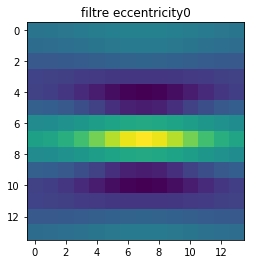

dimension_filtre 16
Pour i_eccentricity = 1  : x, y =  928 868
(16, 16)


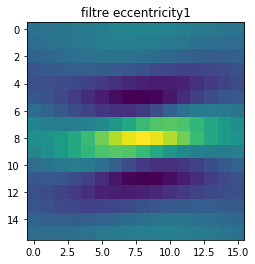

dimension_filtre 18
Pour i_eccentricity = 2  : x, y =  937 859
(18, 18)


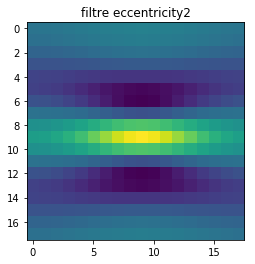

dimension_filtre 20
Pour i_eccentricity = 3  : x, y =  945 870
(20, 20)


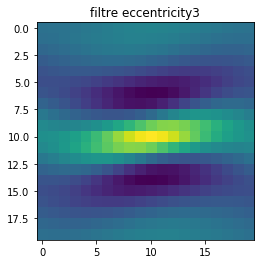

dimension_filtre 22
Pour i_eccentricity = 4  : x, y =  957 859
(22, 22)


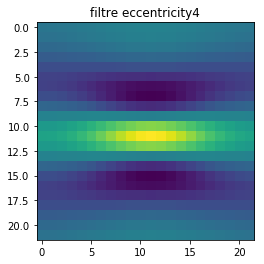

dimension_filtre 24
Pour i_eccentricity = 5  : x, y =  968 873
(24, 24)


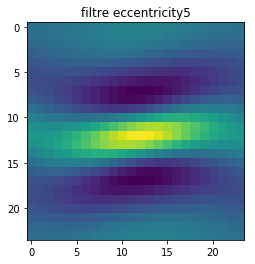

dimension_filtre 28
Pour i_eccentricity = 6  : x, y =  982 859
(28, 28)


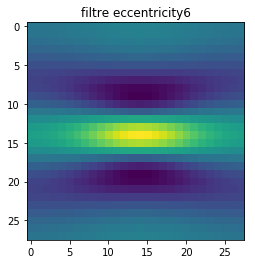

dimension_filtre 30
Pour i_eccentricity = 7  : x, y =  996 877
(30, 30)


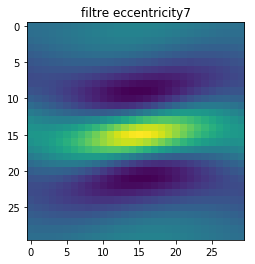

dimension_filtre 34
Pour i_eccentricity = 8  : x, y =  1014 859
(34, 34)


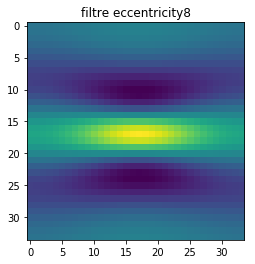

dimension_filtre 38
Pour i_eccentricity = 9  : x, y =  1031 881
(38, 38)


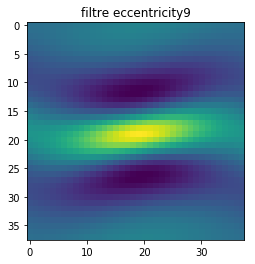

dimension_filtre 42
Pour i_eccentricity = 10  : x, y =  1054 859
(42, 42)


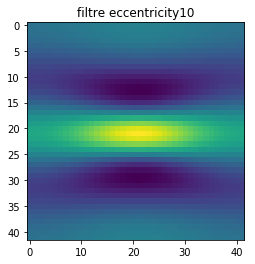

dimension_filtre 48
Pour i_eccentricity = 11  : x, y =  1076 887
(48, 48)


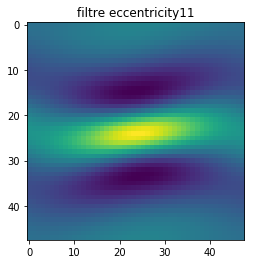

dimension_filtre 54
Pour i_eccentricity = 12  : x, y =  1104 859
(54, 54)


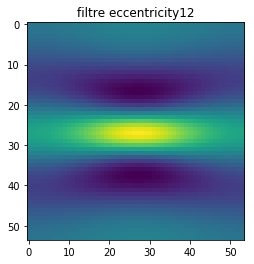

dimension_filtre 60
Pour i_eccentricity = 13  : x, y =  1132 894
(60, 60)


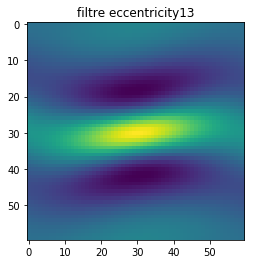

dimension_filtre 68
Pour i_eccentricity = 14  : x, y =  1168 859
(68, 68)


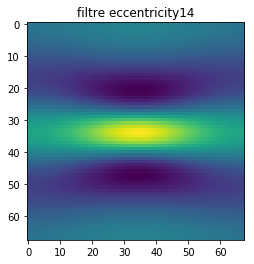

dimension_filtre 76
Pour i_eccentricity = 15  : x, y =  1202 904
(76, 76)


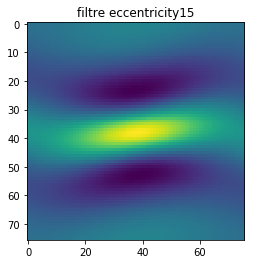

dimension_filtre 86
Pour i_eccentricity = 16  : x, y =  1247 859
(86, 86)


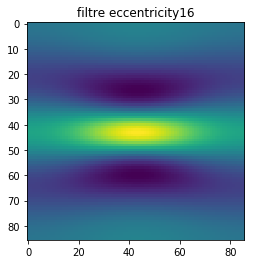

dimension_filtre 96
Pour i_eccentricity = 17  : x, y =  1291 915
(96, 96)


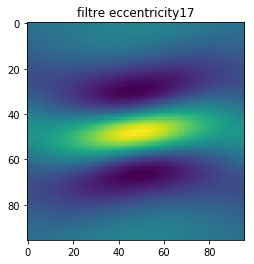

dimension_filtre 108
Pour i_eccentricity = 18  : x, y =  1347 859
(108, 108)


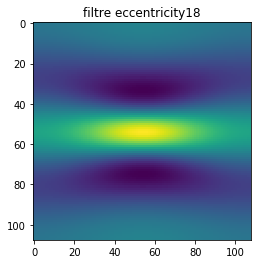

dimension_filtre 120
Pour i_eccentricity = 19  : x, y =  1402 930
(120, 120)


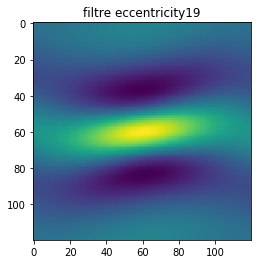

dimension_filtre 134
Pour i_eccentricity = 20  : x, y =  1473 859
(134, 134)


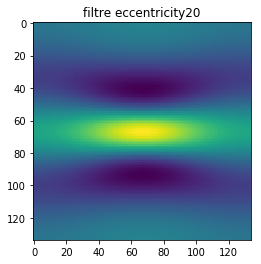

dimension_filtre 152
Pour i_eccentricity = 21  : x, y =  1542 948
(152, 152)


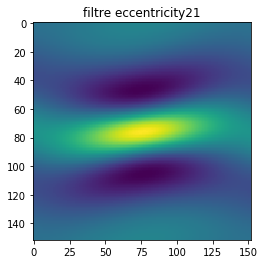

dimension_filtre 170
Pour i_eccentricity = 22  : x, y =  1631 859
(170, 170)


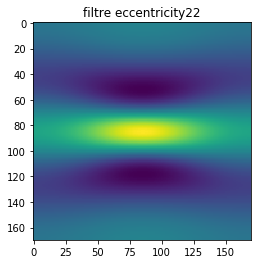

dimension_filtre 190
Pour i_eccentricity = 23  : x, y =  1718 972
(190, 190)


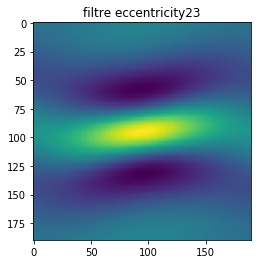

Dico cree
len finale 24


In [15]:
retina_dico = creation_retina_dico()
#print(type(retina_dico))

## Affichage position filtres sur l'image

### Chargement et affichage une image

In [76]:
from skimage import io
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

In [77]:
class EssaiChicagoFacesDataset:
    """Chicago Faces dataset."""

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.init_get_path_files()

    def init_get_path_files(self):
        self.list_files = []
        self.dic_sample = {}
        folder_directory = self.root_dir

        for path, subdirs, files in os.walk(folder_directory):
            for name in files:
                if name[-4:] == '.jpg':
                    #print(path, name)
                    self.list_files.append(os.path.join(path, name))
        # print(self.list_files)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, idx):
        #img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        img_name = os.path.join(self.list_files[idx])
        #image = io.imread(img_name, as_gray=True)
        #image = np.load(img_name)
        #image = np.array(Image.open("../data/ChicagoFacesData/BM-021/CFD-BM-021-026-A.jpg"))
        image = np.array(Image.open(img_name))
        image = self.SquareCrop(image)
        name_image = self.list_files[idx][-28:-4]
        target = self.list_files[idx][-5:-4]
        if target == 'C' or target == 'O':
            target = self.list_files[idx][-6:-4]
        self.dic_sample[idx] = [name_image, image, target]
        return self.dic_sample[idx]
    
    def SquareCrop(self, image):
        h, w = image.shape[:2]
        dim = min(h, w)
        image = image[h//2-dim//2:h//2+dim//2, w//2-dim//2:w//2+dim//2]
        return image
        

In [78]:
faces_dataset = EssaiChicagoFacesDataset(csv_file='../data/ChicagoFacesData/CFD_2.0.3_Norming_Data_and_Codebook.csv',
                                    root_dir='../data/ChicagoFacesData/')

In [79]:
index_image = np.random.randint(len(faces_dataset))

1191


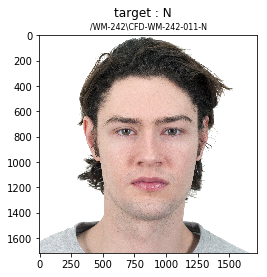

In [80]:
print(index_image)
plt.gray() # l'image est déjà en niveaux de gris, c'est juste pour éviter d'avoir l'affichage entre bleu et jaune
plt.suptitle("target : " + faces_dataset[index_image][2], fontsize=12)
plt.title(faces_dataset[index_image][0], fontsize=8)
plt.imshow(faces_dataset[index_image][1])
plt.show()


### Position des filtres

[891.207857978765, 890.1104018311395, 886.8928232110918, 881.774394784278, 875.1039289893824, 867.3360070468616, 859.0, 850.6639929531384, 842.8960710106176, 836.225605215722, 831.1071767889082, 827.8895981688605, 826.792142021235, 827.8895981688605, 831.1071767889082, 836.225605215722, 842.8960710106176, 850.6639929531384, 859.0, 867.3360070468615, 875.1039289893824, 881.774394784278, 886.8928232110918, 890.1104018311395, 898.4164205772686, 895.7302566536426, 890.54098643869, 883.2022501218852, 874.2141704553834, 864.1892702149527, 853.8107297850473, 843.7858295446166, 834.7977498781148, 827.45901356131, 822.2697433463574, 819.5835794227314, 819.5835794227314, 822.2697433463574, 827.45901356131, 834.7977498781147, 843.7858295446166, 853.8107297850473, 864.1892702149527, 874.2141704553834, 883.2022501218852, 890.54098643869, 895.7302566536426, 898.4164205772686, 907.2212327122305, 905.5781340522386, 900.7608125305928, 893.0975606479927, 883.1106163561152, 871.4805734042459, 859.0, 846.

<Figure size 1440x1440 with 0 Axes>

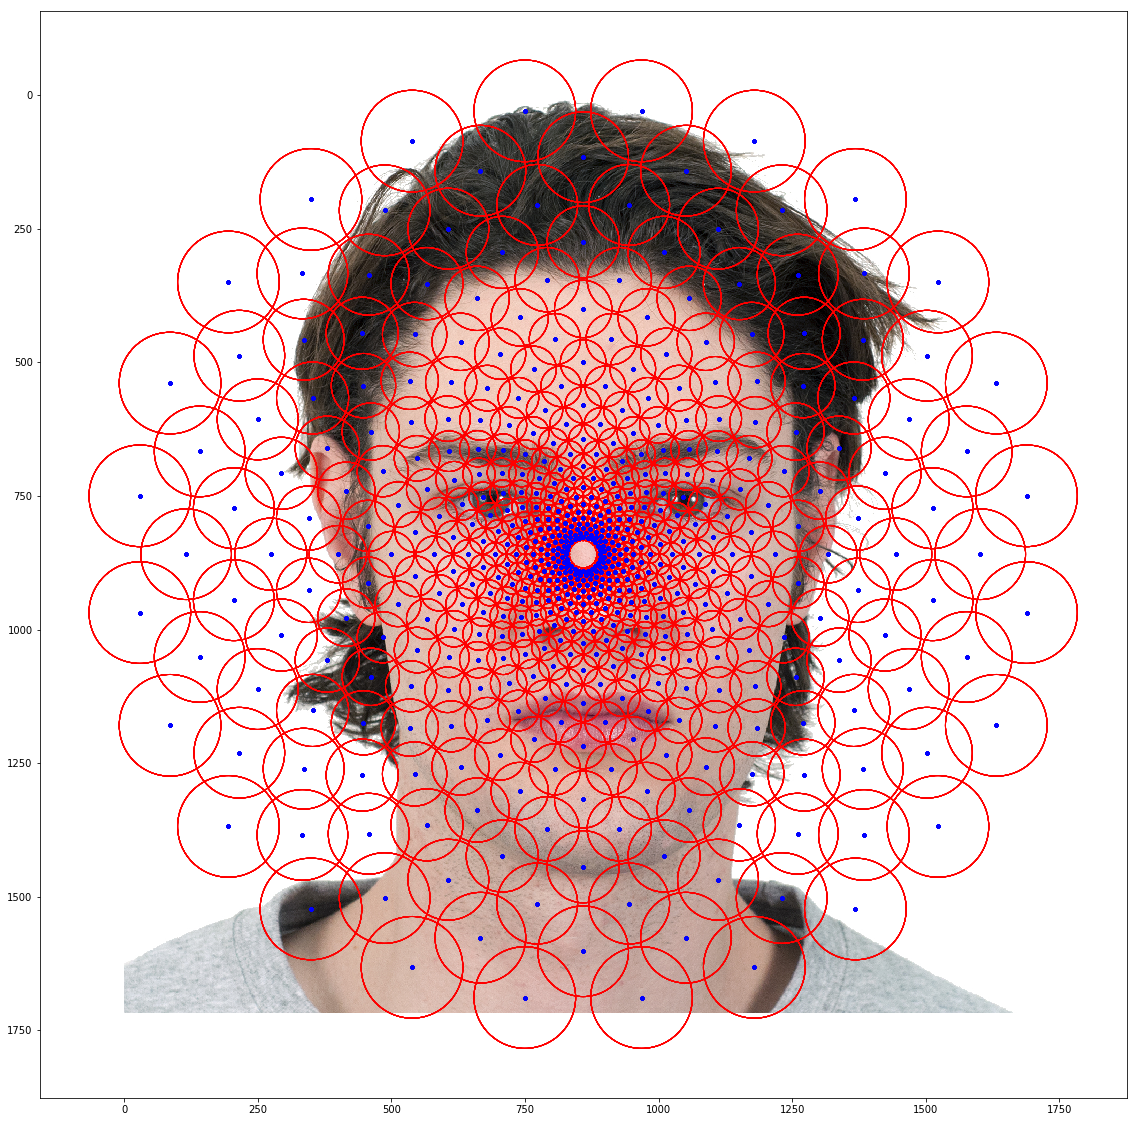

In [98]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(20,20))
fig, ax = plt.subplots(figsize=(20,20))

plt.imshow(faces_dataset[index_image][1])


liste_x = []
liste_y = []
liste_r = []
liste_sf_0 = []

N_X = args.N_pic
N_Y = args.N_pic

for i_theta in range(args.N_theta):
    for i_phase in range(args.N_phase):
        for i_eccentricity in range(args.N_eccentricity):
            for i_azimuth in range(args.N_azimuth):
                ecc_max = 0.8 # 0.6  # initialement 0.8 # self.args.ecc_max  # gross. aptitude a grandir
                sf_0_r = 0.015  # initialement 0.03 # self.args.sf_0_r # gross. la "diminution" de taille pour les ecc moyennes
                #B_theta = np.pi / args.N_theta / 2  # self.args.B_theta
                #B_sf = 0.4 # initialement 0.4 # gross. le nombre de lobes
                sf_0_max = 0.45 # 0.05 # initialement 0.45 # gross. taille initiale

                ecc = ecc_max * (1 / args.rho) ** ((args.N_eccentricity - i_eccentricity*1)/3) # /3 ajouté
                r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc -30 # radius
                #print(r)

                #dimension_filtre = min(2 * int(2 * r), args.N_pic)  # 2*int(2*r) pour avoir des filtres vraiment de la meme taille qu'avant
                #print("dimension_filtre", dimension_filtre)
                #if dimension_filtre < 200 : 
                #    dimension_filtre = 200
                #print("dimension_filtre", dimension_filtre)
                #lg.set_size((dimension_filtre, dimension_filtre))

                #lg.set_size((N_X, N_Y))

                # psi = i_azimuth * np.pi * 2 / N_azimuth
                psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
                #theta_ref = i_theta * np.pi / args.N_theta
                sf_0 = 0.5 * sf_0_r / ecc
                sf_0 = np.min((sf_0, sf_0_max))
                # TODO : find the good ref for this                print(sf_0)
                x = N_X / 2 + r * np.cos(psi)  # c'est bien le centre du filtre ?
                y = N_Y / 2 + r * np.sin(psi)  # c'est bien le centre du filtre ?
                #print("Pour i_eccentricity =", i_eccentricity, ' : x, y = ', int(x), int(y))
                
                liste_x.append(x)
                liste_y.append(y)
                liste_r.append(r)
                liste_sf_0.append(sf_0)
                
 
for i in range(len(liste_x)):
    circle = patches.Circle((liste_y[i],liste_x[i]), radius=1/liste_sf_0[i], color='r', fill=False)
    ax.add_patch(circle)
    
print(liste_x[0:100])
print(liste_y[0:100])
print(liste_sf_0[0:100])
print(len(liste_x))
ax.plot(liste_y, liste_x,'.', color='b')
plt.show()
                